In [47]:
import os 
from glob import glob
import itertools as it 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

# change dir to project dir
if 'changed' not in globals():
    os.chdir('../../../../')
    changed = 1

outdir = 'results/motif_pairs/chrom_correction_only.fast.with_blacklist/summary/'
os.makedirs(outdir, exist_ok=True)

In [48]:
# output directory for simulations
num_top_motifs = 50
#num_top_motifs = 100 
SAMPLE_NAME='*'

pulldown = 'CTCF'
#pulldown = 'H3K27ac'

mp_data_dir = 'results/motif_pairs/chrom_correction_only.fast.with_blacklist/'
glob_path = mp_data_dir + f'{SAMPLE_NAME}/Q_values_sig.top_{num_top_motifs}_count.tsv'
fns = glob(glob_path.format(glob_path))

# filter for samples with the current pulldown
fns = [x for x in fns if pulldown in x]

In [49]:
# load the data
data = []
for fn in fns:

    sample_name = fn.split('/')[-2]
    tdf = pd.read_table(fn)
    tdf['sample_name'] = sample_name
    data.append(tdf)

all_df = pd.concat(data)
all_df = all_df.loc[all_df['Q_value'] < 0.05]
#all_df = all_df.loc[all_df['Q_value'] < 0.00001]
print(all_df.shape)

(212, 9)


In [50]:
# sort the pairs before working with them
def sort_pairs(sr):
    pairs_list = [sr.Motif1, sr.Motif2]
    return(sorted(pairs_list))
anchor_sorted_1, anchor_sorted_2 = zip(*all_df.apply(sort_pairs, axis=1))
all_df.loc[:, 'anchor_sorted_1'] = anchor_sorted_1
all_df.loc[:, 'anchor_sorted_2'] = anchor_sorted_2
all_df.loc[:, 'pair_sorted'] = all_df.loc[:, 'anchor_sorted_1'] + ',' + all_df.loc[:, 'anchor_sorted_2']

In [51]:
def get_log10(x, replace_inf=1000000):
    log_val = -np.log(x)
    if log_val < np.inf:
        return(log_val)
    else:
        return(replace_inf)
    
# set replace_inf = 12 because 
# all_df.loc[~np.isinf(all_df['-log_qvalue'])]['-log_qvalue'].max() == 11
all_df.loc[:, '-log_qvalue'] = all_df.Q_value.apply(get_log10, args=[11])
#all_df.loc[:, '-log_qvalue'] = all_df.Q_value.apply(lambda x: -np.log(x))

/mnt/BioHome/jreyna/tmp/ipykernel_1617331/1728400676.py:2: RuntimeWarning: divide by zero encountered in log
  log_val = -np.log(x)


### Summary of Motif Pairs

In [52]:
# mp_grps = all_df.groupby('pair_sorted')
# mp_counts_ss = mp_grps.count()


mp_grps = all_df.groupby(['pair_sorted']) 
mp_counts_ss = mp_grps.count()['Motif1'].rename('pair_count').to_frame()
mp_counts_ss.sort_values(['pair_count'], ascending=[False], inplace=True)

In [53]:
mp_counts_ss.head()

,pair_count
pair_sorted,
"CTCF,ZNF460",9
"KLF15,PATZ1",8
"ZNF135,ZNF460",7
"KLF5,PATZ1",5
"KLF5,KLF5",5


### Summary of 1D Motif

In [54]:
left_df = all_df.drop(['anchor_sorted_2'], axis=1).rename(columns={'anchor_sorted_1': 'Motif'})
right_df = all_df.drop(['anchor_sorted_1'], axis=1).rename(columns={'anchor_sorted_2': 'Motif'})
oned_motif_df = pd.concat([left_df, right_df])

In [55]:
motif_grps = oned_motif_df.groupby(['Motif']) 
motif_counts_ss = motif_grps.count()['Motif1'].rename('motif_count').to_frame()
motif_counts_ss.sort_values(['motif_count'], ascending=[False], inplace=True)

In [56]:
motif_counts_ss

,motif_count
Motif,
ZNF460,54
KLF15,50
PATZ1,46
KLF5,43
ZNF281,33
ZNF135,32
KLF16,29
ZNF93,28
ZNF148,26


#### Making a jointplot of the motif-pair frequencies for different sample sets 

In [57]:
# extract the counts for the current set
a_plus_counts = mp_counts_ss.copy(deep=True)

# take the top n only
topn = 10000
topn = 25

# finding the topn pairs
a_plus_counts_topn = a_plus_counts.sort_values('pair_count', ascending=False).iloc[0:topn]

In [58]:
a_plus_counts

,pair_count
pair_sorted,
"CTCF,ZNF460",9
"KLF15,PATZ1",8
"ZNF135,ZNF460",7
"KLF5,PATZ1",5
"KLF5,KLF5",5
...,...
"ZFP42,ZNF460",1
"ZNF135,ZNF281",1
"ZNF384,ZNF8",1


In [59]:
# for plotting, adding back the self-pairs
pairs_for_plotting = a_plus_counts_topn.index.tolist()
tmp_motifs = list(set(it.chain(*[x.split(',') for x in pairs_for_plotting])))
self_motifs = ['{},{}'.format(x,x) for x in tmp_motifs]
self_motifs = [x for x in self_motifs if x in a_plus_counts.index]
pairs_for_plotting += self_motifs
a_plus_counts = a_plus_counts.loc[a_plus_counts.index.isin(pairs_for_plotting)]

In [60]:
# convert the index into two columns and sort 
left_anchors, right_anchors = list(zip(*map(lambda x: x.split(','), a_plus_counts.index)))
a_plus_counts['anchor_sorted_1'] = left_anchors
a_plus_counts['anchor_sorted_2'] = right_anchors
a_plus_counts.sort_values(['anchor_sorted_1', 'anchor_sorted_2'], ascending=[False, False], inplace=True)

# add reverse in order to have a symmetric matrix after pivoting 
a_plus_counts_rev = a_plus_counts.rename(columns={'anchor_sorted_1': 'anchor_sorted_2', 'anchor_sorted_2': 'anchor_sorted_1'})
a_plus_counts = pd.concat([a_plus_counts, a_plus_counts_rev])

# pivot the data into matrix for and fillna
a_plus_counts_matrix = a_plus_counts.pivot_table(index='anchor_sorted_2', columns='anchor_sorted_1', values='pair_count', fill_value=0)
#a_plus_counts_matrix.fillna(0, inplace=True)

# reverse the index values 
rev_index = list(reversed(sorted(a_plus_counts_matrix.index)))
a_plus_counts_matrix = a_plus_counts_matrix.loc[:, rev_index]

/mnt/BioHome/jreyna/tmp/ipykernel_1617331/104264049.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a_plus_counts['anchor_sorted_1'] = left_anchors
/mnt/BioHome/jreyna/tmp/ipykernel_1617331/104264049.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a_plus_counts['anchor_sorted_2'] = right_anchors
/mnt/BioHome/jreyna/tmp/ipykernel_1617331/104264049.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyda

In [61]:
a_plus_counts_matrix.shape

(12, 12)

In [62]:
# calculate frequencies for the column panel
col_idxs = a_plus_counts_matrix.columns.tolist()
col_oned_motif_counts = motif_counts_ss.loc[col_idxs].reset_index()

# calculate frequencies for the row panel
row_idxs = a_plus_counts_matrix.index.tolist()
row_oned_motif_counts = a_plus_counts_matrix.sum().loc[row_idxs].to_frame().reset_index()
row_oned_motif_counts.columns = ['Motif', 'topn_freq']

# calculating the number 
num_a_samples = all_df.drop_duplicates(['sample_name']).shape[0]

In [63]:
#fig = plt.figure(figsize=(8, 6))
#fig = plt.figure(figsize=(16, 12))

generate_plot1 = False
if generate_plot1 == True:
        
    fig = plt.figure(figsize=(32, 24))

    hspace = 0.03
    wspace = 0.05

    purple_rgb = tuple([0.57916573903086, 0.33934576125314425, 0.5219003947563425])

    # making the gridspec and separating each piece
    grid = GridSpec(2, 4, figure=fig, height_ratios=[1, 3], width_ratios=[3, 1, 0.5, 0.1], hspace=hspace, wspace=wspace)

    top_panel = fig.add_subplot(grid[0, 0])
    large_box = fig.add_subplot(grid[1, 0])

    right_panel = fig.add_subplot(grid[1, 1])
    legend_panel = fig.add_subplot(grid[1, 3])

    # drawing a heatmap in the large box
    #sns.heatmap(a_plus_counts_matrix, robust=False, ax=large_box, xticklabels=True, yticklabels=True, cbar_kws={'location': 'bottom'})
    sns.heatmap(a_plus_counts_matrix / num_a_samples, robust=False, ax=large_box, annot=a_plus_counts_matrix,
                xticklabels=True, yticklabels=True,
                cbar=True, cbar_ax=legend_panel, 
                cmap=sns.cubehelix_palette(as_cmap=True), linewidths=0.003,
                cbar_kws={'label': 'Proportion of Samples with Q-value < 0.05 (N = {})'.format(num_a_samples), 'location': 'left'})
    large_box.set(xlabel='', ylabel='')

    # drawing a barplot of 1D motif frequencies across the whole genome
    sns.barplot(x='Motif', y='Sim_Count', data=col_oned_motif_counts, color=purple_rgb, ax=top_panel)
    top_panel.set(xticklabels=[], xlabel='', ylabel='Genome-wide\nFrequency', xticks=[])
    sns.despine(ax=top_panel, right=True, top=True)

    # drawing a barplot of 1D motif frequencies across the top 25 motif pairs
    sns.barplot(y='Motif', x='topn_freq', data=row_oned_motif_counts, color=purple_rgb, ax=right_panel)
    right_panel.set(yticklabels=[], ylabel='', xlabel=f'Top {topn}\nFrequency', yticks=[])
    sns.despine(ax=right_panel, right=True, top=True)

    # save the figure 
    fn = os.path.join(outdir, f'motif_pair_distributions.{topn}.{pulldown}.png')
    fig.savefig(fn, dpi=600, bbox_inches='tight')

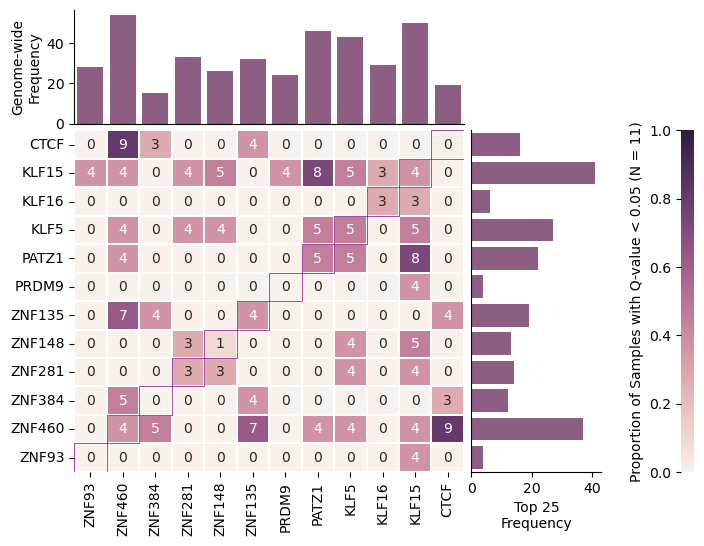

In [64]:
fig = plt.figure(figsize=(8, 6))
#fig = plt.figure(figsize=(16, 12))
#fig = plt.figure(figsize=(32, 24))

vopt_dict = {25: {'vmin': 0, 'vmax': 1, 'linewidths': 0.5},
             100: {'vmin': 0.25, 'vmax': 1, 'linewidths': 1},
             10000: {'vmin': 0, 'vmax': 1, 'linewidths': 1}}
generate_plot1 = True
if generate_plot1 == True:
    
    hspace = 0.03
    wspace = 0.05

    purple_rgb = tuple([0.57916573903086, 0.33934576125314425, 0.5219003947563425])

    # making the gridspec and separating each piece
    grid = GridSpec(2, 4, figure=fig, height_ratios=[1, 3], width_ratios=[3, 1, 0.5, 0.1], hspace=hspace, wspace=wspace)

    top_panel = fig.add_subplot(grid[0, 0])
    large_box = fig.add_subplot(grid[1, 0])

    right_panel = fig.add_subplot(grid[1, 1])
    legend_panel = fig.add_subplot(grid[1, 3])

    # drawing a heatmap in the large box
    #sns.heatmap(a_plus_counts_matrix, robust=False, ax=large_box, xticklabels=True, yticklabels=True, cbar_kws={'location': 'bottom'})
    sns.heatmap(a_plus_counts_matrix / num_a_samples, robust=False, ax=large_box, annot=a_plus_counts_matrix,
                xticklabels=True, yticklabels=True,
                cbar=True, cbar_ax=legend_panel, 
                cmap=sns.cubehelix_palette(light=0.95, as_cmap=True), linewidths=0.003,
                vmin=vopt_dict[topn]['vmin'], vmax=vopt_dict[topn]['vmax'],
                cbar_kws={'label': 'Proportion of Samples with Q-value < 0.05 (N = {})'.format(num_a_samples), 'location': 'left'})
    large_box.set(xlabel='', ylabel='')
    
    # Draw borders around both the diagonal
    for i in range(a_plus_counts_matrix.shape[0]):
        for j in range(a_plus_counts_matrix.shape[1]):
            if i == (a_plus_counts_matrix.shape[0] - j - 1):
                large_box.add_patch(plt.Rectangle((j, i), 1, 1,
                                                  fill=False,
                                                  edgecolor='purple',
                                                  linewidth=vopt_dict[topn]['linewidths']))

    # drawing a barplot of 1D motif frequencies across the whole genome
    sns.barplot(x='Motif', y='motif_count', data=col_oned_motif_counts, color=purple_rgb, ax=top_panel)
    top_panel.set(xticklabels=[], xlabel='', ylabel='Genome-wide\nFrequency', xticks=[])
    sns.despine(ax=top_panel, right=True, top=True)

    # drawing a barplot of 1D motif frequencies across the top 25 motif pairs
    sns.barplot(y='Motif', x='topn_freq', data=row_oned_motif_counts, color=purple_rgb, ax=right_panel)
    right_panel.set(yticklabels=[], ylabel='', xlabel=f'Top {topn}\nFrequency', yticks=[])
    sns.despine(ax=right_panel, right=True, top=True)

    # save the figure 
    fn = os.path.join(outdir, f'motif_pair_distributions.vopts.{topn}.{pulldown}.png')
    fig.savefig(fn, dpi=600, bbox_inches='tight')

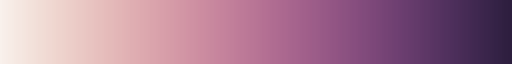

In [65]:
sns.cubehelix_palette(light=0.95, as_cmap=True)

In [66]:
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Create sample data
# data = np.random.rand(10, 10)

# # Create the heatmap using seaborn
# sns.heatmap(data, cmap='coolwarm')

# # Draw borders around both main and opposite diagonals
# for i in range(data.shape[0]):
#     for j in range(data.shape[1]):
#         if i == (data.shape[0] - j - 1):
#             plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='red', linewidth=2))

# # Show the plot
# plt.show()


## Generating the Supplementary Table 

In [67]:
mp_list = a_plus_counts_matrix.columns.tolist()
top_25_motifs_all_df = all_df.loc[all_df.Motif1.isin(mp_list) & all_df.Motif2.isin(mp_list)]

top_25_motifs_all_df.sort_values(['sample_name', 'pair_sorted'], inplace=True)

# dropping and reordering columns
top_25_motifs_all_df = top_25_motifs_all_df[['sample_name', 'Motif1', 'Motif2', 'Obs_Count', 'Sim_Count', 'P_value', 'Q_value']]

# rename the columns
top_25_motifs_all_df.columns = ['Sample Name', 'Motif1', 'Motif2',
                                'Observed Count', 'Simulated Count', 'P-value', 'Q-value']

# save the table
fn = os.path.join(outdir, f'top{topn}.{pulldown}.motif-pairs.sample-wise.tsv')
top_25_motifs_all_df.to_csv(fn, sep='\t', index=False)

/mnt/BioHome/jreyna/tmp/ipykernel_1617331/302033250.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_25_motifs_all_df.sort_values(['sample_name', 'pair_sorted'], inplace=True)
